In [145]:
from datetime import datetime
from typing import List, Dict
import re
from typing import List, Tuple

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.fixes import signature
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, \
roc_auc_score, average_precision_score, homogeneity_score, silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN



from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline 

In [17]:
# Import pandas and read csv
df_o = pd.read_csv("./data/chapter_3/banksim.csv")


# Exploring the data

In [18]:
df_o.columns

Index(['Unnamed: 0', 'age', 'gender', 'category', 'amount', 'fraud'], dtype='object')

In [20]:
print(df_o.shape)
df_o.head(10)

print(df_o.groupby('category').mean())

(7200, 6)
                          Unnamed: 0      amount     fraud
category                                                  
es_barsandrestaurants  267372.707865   43.841793  0.022472
es_contents            335906.153846   55.170000  0.000000
es_fashion             286952.226804   59.780769  0.020619
es_food                334978.976190   35.216050  0.000000
es_health              335355.176955  126.604704  0.242798
es_home                248312.583333  120.688317  0.208333
es_hotelservices       280138.548387  172.756245  0.548387
es_hyper               244440.712500   46.788180  0.125000
es_leisure             186541.307692  229.757600  1.000000
es_otherservices       241279.000000  149.648960  0.600000
es_sportsandtoys       238775.539474  157.251737  0.657895
es_tech                310473.948718  132.852862  0.179487
es_transportation      295733.881674   27.422014  0.000000
es_travel              338897.777778  231.818656  0.944444
es_wellnessandbeauty   275085.979798   66.1670

In [21]:
# the majority of fraud is observed in travel, leisure and sports related transactions.

# Customer segmentation


In [26]:
# Group by age groups and get the mean
print(df_o.groupby('age').mean())
print('\n')
# Count the values of the observations in each age group
print(df_o['age'].value_counts())

        Unnamed: 0     amount     fraud
age                                    
0    327520.450000  49.468935  0.050000
1    290985.509116  35.622829  0.026648
2    296867.958851  37.228665  0.028718
3    291471.417346  37.279338  0.023283
4    306041.396403  36.197985  0.035966
5    290885.960859  37.547521  0.023990
6    299193.716561  36.700852  0.022293
U    288372.181818  39.117000  0.000000


2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64


In [27]:
#  the average amount spent as well as fraud occurrence is rather similar across groups. 
# Age group '0' stands out but since there are only 40 cases, it does not make sense to split these out in a separate group 
# and run a separate model on them.

### Using statistics to define normal behavior


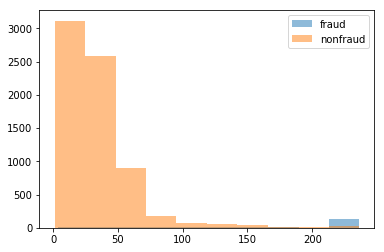

In [32]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = df_o[df_o.fraud == 1] 
df_non_fraud = df_o[df_o.fraud == 0]


# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.legend()
plt.show()

## process the data

In [48]:
print(df_o.columns)

for column in list(df_o.columns):
    print(df_o[column].value_counts())

Index(['Unnamed: 0', 'age', 'gender', 'category', 'amount', 'fraud'], dtype='object')
591871    1
58614     1
363843    1
294213    1
394993    1
365693    1
308556    1
58702     1
103760    1
296274    1
183635    1
290135    1
589149    1
300384    1
245093    1
548201    1
525674    1
294253    1
372079    1
438074    1
536412    1
347507    1
217323    1
290167    1
256876    1
413051    1
435582    1
114085    1
464192    1
36155     1
         ..
363904    1
424706    1
422463    1
420552    1
461532    1
238281    1
228042    1
131789    1
189787    1
4815      1
584400    1
391890    1
373459    1
314068    1
365555    1
8509      1
443101    1
45819     1
169284    1
76512     1
247514    1
266983    1
37170     1
412396    1
236270    1
557542    1
396020    1
168695    1
436984    1
473385    1
Name: Unnamed: 0, Length: 7200, dtype: int64
2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64
F    3972
M    3212
E      11
U  

In [79]:
def _remove_unknow_gender(df: pd.DataFrame) -> pd.DataFrame:
    df = df[~df.gender.str.contains('E|U', regex=True)]
    return df

F    3972
M    3212
E      11
U       5
Name: gender, dtype: int64

In [165]:
def process_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    df = _remove_unknow_gender(df)
    df = df.drop('Unnamed: 0', axis=1)
    df = pd.get_dummies(df, columns=['gender', 'category'])
    df = df.drop('gender_F', axis=1)
    
    df_label = df['fraud']
    df_features = df.drop(columns='fraud')
    return df_features, df_label

df, labels = process_data(df_o)
y = labels

### Scaling the data


In [116]:
def scaling_data(df: pd.DataFrame) -> np.array:

    # Transform df into a numpy array
    X = np.array(df).astype(np.float)

    # Define the scaler and apply to the data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

X_scaled = scaling_data(df)    

## K-means clustering


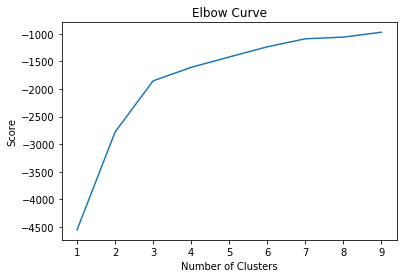

In [119]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## Detecting outliers


In [138]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_        # Coordinates of cluster centers.
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

### Checking model results


In [139]:
# Obtain the ROC score
print(roc_auc_score(y_test, km_y_pred))

# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)
print(km_cm)
# Plot the confusion matrix in a figure to visualize results 


0.7930402930402931
[[2024   69]
 [  24   39]]


### decrease the percentile

In [140]:
# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 93)] = 1
km_y_pred[dist < np.percentile(dist, 93)] = 0

In [141]:
km_cm = confusion_matrix(y_test, km_y_pred)
print(km_cm)

[[1986  107]
 [  19   44]]


In [142]:
# By lowering the threshold for cases flagged as fraud, you flag more cases overall but thereby also get more false positives.

## DB scan


In [187]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled) # maximum distance between two samples to 0.9

# Obtain the predicted labels,these are the cluster numbers assigned to an observation.
pred_labels = db.labels_

# calculate number of clusters
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)     # ?? why -1

# Print performance metrics for DBscan
print('Estimated number of clusters: %d' % n_clusters)

# Homogeneity metric of a cluster labeling given a ground truth.
print("Homogeneity: %0.3f" % homogeneity_score(labels, pred_labels))  

print("Silhouette Coefficient: %0.3f" % silhouette_score(X_scaled, pred_labels))


Estimated number of clusters: 23
Homogeneity: 0.612
Silhouette Coefficient: 0.715


### Assessing smallest clusters


In [188]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)


# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

# Print the results 
print("The smallest clusters are clusters:")      
print(smallest_clusters)

# Print the counts of the smallest clusters only
print("Their counts are:")      
print(counts[smallest_clusters])

[3249  144 2714   55  173  119  122   98   54   15   76   15   43   25
   51   47   42   15   25   20   19   10]
The smallest clusters are clusters:
[21 17  9]
Their counts are:
[10 15 15]


In [171]:
# So now we know which smallest clusters you could flag as fraud. If you were to take more of the smallest clusters,
# you cast your net wider and catch more fraud, but most likely also more false positives. It is up to the fraud analyst
# to find the right amount of cases to flag and to investigate. In the next exercise you'll check the results with the 
# actual labels.

## Checking results


In [172]:
#  In reality, you often don't have reliable labels and this where a fraud analyst can help you validate the results.
# He/She can check your results and see whether the cases you flagged are indeed suspicious. You can also check historically 
# known cases of fraud and see whether your model flags them.

In [189]:
# Create a dataframe of the predicted cluster numbers and fraud labels 
df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters 
df['predicted_fraud'] = np.where((df.clusternr == 21)|(df.clusternr == 17)|(df.clusternr == 9),1 , 0)

# Run a crosstab on the results 
print(pd.crosstab(df.fraud, df.predicted_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0   1
Actual Fraud           
0              6968  16
1               176  24


In [177]:
#Success! How does this compare to the K-means model? The good thing is: our of all flagged cases, roughly 2/3 are actually 
#fraud! Since you only take the three smallest clusters, by definition you flag less cases of fraud, so you catch less
#but also have less false positives. However, you are missing quite a lot of fraud cases. Increasing the amount of smallest
#clusters you flag could improve that, at the cost of more false positives of course. In the next chapter you'll learn how
#to further improve fraud detection models by including text analysis.

### increase the amount of smallest clusters

In [190]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:5]

print("The smallest clusters are clusters:")      
print(smallest_clusters)
print("Their counts are:")      
print(counts[smallest_clusters])

The smallest clusters are clusters:
[21 17  9 11 20]
Their counts are:
[10 15 15 15 19]


In [191]:
df['predicted_fraud'] = np.where((df.clusternr == 21)|(df.clusternr == 17)|(df.clusternr == 9) 
                                 | (df.clusternr == 11)|(df.clusternr == 20) ,1 , 0)
print(pd.crosstab(df.fraud, df.predicted_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0   1
Actual Fraud           
0              6946  38
1               164  36


## perform on train and test set   ?? not working? 

In [198]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_train) # maximum distance between two samples to 0.9

# Obtain the predicted labels,these are the cluster numbers assigned to an observation.
pred_labels = db.labels_

# calculate number of clusters
n_clusters = len(set(db.labels_)) - (1 if -1 in labels else 0)     # ?? why -1

# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)


# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:10]

# Print the results 
print("The smallest clusters are clusters:")      
print(smallest_clusters)

# Print the counts of the smallest clusters only
print("Their counts are:")      
print(counts[smallest_clusters])




[2286   65 1905  114   29   12  100   50   26   85   37   10   13   39
   88   35   10   11   30   10   17   18]
The smallest clusters are clusters:
[19 16 11 17  5 12 20 21  8  4]
Their counts are:
[10 10 10 11 12 13 17 18 26 29]


In [199]:
# Create a dataframe of the predicted cluster numbers and fraud labels 
df = pd.DataFrame({'clusternr':db.fit_predict(X_test),'fraud':y_test})

# Create a condition flagging fraud for the smallest clusters 
df['predicted_fraud'] = np.where((df.clusternr == 19)|(df.clusternr == 16)|(df.clusternr == 11)
                                 | (df.clusternr == 17)|(df.clusternr == 5)|(df.clusternr == 12)
                                 | (df.clusternr == 20)|(df.clusternr == 21)|(df.clusternr == 8), 1 , 0)

# Run a crosstab on the results 
print(pd.crosstab(df.fraud, df.predicted_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0    1
Actual Fraud            
0              1975  118
1                56    7
